### Uploading to S3

In [9]:
from utils import *

import boto3
import sagemaker

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sagemaker_session.default_bucket()

prefix='dengai'

train_prefix   = '{}/{}'.format(prefix, 'train')
test_prefix    = '{}/{}'.format(prefix, 'test')

train_path  = sagemaker_session.upload_data(TRAIN_JSON, bucket=bucket, key_prefix=train_prefix)
test_path_sj   = sagemaker_session.upload_data(TEST_JSON_SJ,  bucket=bucket, key_prefix=test_prefix)
test_path_iq   = sagemaker_session.upload_data(TEST_JSON_IQ,  bucket=bucket, key_prefix=test_prefix)

### Creating training job

In [3]:
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.estimator import Estimator

image_name = get_image_uri(boto3.Session().region_name, 'forecasting-deepar') 
s3_output_path_iq = "s3://{}/{}/output_sj".format(bucket, prefix)
s3_output_path_sj = "s3://{}/{}/output_iq".format(bucket, prefix)

estimator_sj = Estimator(sagemaker_session=sagemaker_session,
                      image_name=image_name,
                      role=role,
                      train_instance_count=1,
                      train_instance_type='ml.c4.xlarge',
                      output_path=s3_output_path_sj
                      )

estimator_iq = Estimator(sagemaker_session=sagemaker_session,
                      image_name=image_name,
                      role=role,
                      train_instance_count=1,
                      train_instance_type='ml.c4.xlarge',
                      output_path=s3_output_path_iq
                      )

freq='W'
hyperparameters_sj = {
    "epochs": "50",
    "time_freq": freq,
    "prediction_length": str(PREDICTION_LENGTH_SJ),
    "context_length": str(PREDICTION_LENGTH_SJ),
    "num_cells": "50",
    "num_layers": "2",
    "mini_batch_size": "128",
    "learning_rate": "0.001",
    "early_stopping_patience": "10"
}
hyperparameters_iq = {
    "epochs": "50",
    "time_freq": freq,
    "prediction_length": str(PREDICTION_LENGTH_IQ),
    "context_length": str(PREDICTION_LENGTH_IQ),
    "num_cells": "50",
    "num_layers": "2",
    "mini_batch_size": "128",
    "learning_rate": "0.001",
    "early_stopping_patience": "10"
}

data_channels = {"train": train_path}

In [4]:
estimator_sj.set_hyperparameters(**hyperparameters_sj)
estimator_sj.fit(inputs=data_channels)

2020-04-07 14:34:02 Starting - Starting the training job...
2020-04-07 14:34:03 Starting - Launching requested ML instances...
2020-04-07 14:35:01 Starting - Preparing the instances for training...
2020-04-07 14:35:32 Downloading - Downloading input data...
2020-04-07 14:35:37 Training - Downloading the training image...
2020-04-07 14:36:32 Training - Training image download completed. Training in progress..Arguments: train
[04/07/2020 14:36:34 INFO 140161409189696] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto

In [5]:
estimator_iq.set_hyperparameters(**hyperparameters_iq)
estimator_iq.fit(inputs=data_channels)

2020-04-07 14:48:54 Starting - Starting the training job...
2020-04-07 14:48:56 Starting - Launching requested ML instances...
2020-04-07 14:49:52 Starting - Preparing the instances for training...
2020-04-07 14:50:24 Downloading - Downloading input data...
2020-04-07 14:50:30 Training - Downloading the training image.....Arguments: train
[04/07/2020 14:51:31 INFO 139693896374080] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patience': u''}
[04/07/2020 14:51:31 I

## Testing our model

### If we want to skip training and reuse a previously trained model

In [12]:
sagemaker_session.list_s3_files(bucket, prefix)

['dengai/batch-inference/test.json.out',
 'dengai/batch-inference_iq/test_sj.json.out',
 'dengai/batch-inference_sj/test_iq.json.out',
 'dengai/output/forecasting-deepar-2020-04-02-20-36-06-182/output/model.tar.gz',
 'dengai/output/forecasting-deepar-2020-04-07-13-07-38-457/output/model.tar.gz',
 'dengai/output_iq/forecasting-deepar-2020-04-07-14-34-02-607/output/model.tar.gz',
 'dengai/output_sj/forecasting-deepar-2020-04-07-14-48-54-592/output/model.tar.gz',
 'dengai/test/test.json',
 'dengai/test/test_iq.json',
 'dengai/test/test_sj.json',
 'dengai/train/train.json']

In [4]:
from sagemaker.model import Model

model_file = 'CHANGE PATH HERE'
model_s3_path = f's3://{bucket}/{model_file}'

model = Model(model_data=model_s3_path,
              image=image_name,
             role=role)

### Batch transform

In [37]:
s3_batch_output_path_sj = 's3://{}/{}/batch-inference_sj'.format(bucket, prefix)
s3_batch_output_path_iq = 's3://{}/{}/batch-inference_iq'.format(bucket, prefix)

# use `model` to predict using old models
transformer = estimator_sj.transformer(instance_count=1,
                                instance_type='ml.m4.xlarge',
                                strategy='SingleRecord',
                                assemble_with='Line',
                                output_path=s3_batch_output_path_sj)
transformer.transform(data=test_path_sj, data_type='S3Prefix', content_type=None, split_type='Line')
transformer.wait()

transformer = estimator_iq.transformer(instance_count=1,
                                instance_type='ml.m4.xlarge',
                                strategy='SingleRecord',
                                assemble_with='Line',
                                output_path=s3_batch_output_path_iq)
transformer.transform(data=test_path_iq, data_type='S3Prefix', content_type=None, split_type='Line')
transformer.wait()

Using already existing model: forecasting-deepar-2020-04-07-14-34-02-607


.......................Arguments: serve
No handlers could be found for logger "root"
[04/07/2020 15:25:30 INFO 140338156205888] Estimated memory required per model 125MB.
[04/07/2020 15:25:30 INFO 140338156205888] Estimated available memory 14960MB.
[04/07/2020 15:25:30 INFO 140338156205888] Estimated maximum number of workers for the available memory is 119.
[04/07/2020 15:25:30 INFO 140338156205888] Using 4 workers
[04/07/2020 15:25:30 INFO 140338156205888] loading entry points
[04/07/2020 15:25:30 INFO 140338156205888] Prediction endpoint operating in batch mode
[04/07/2020 15:25:30 INFO 140338156205888] loaded request iterator application/jsonlines
[04/07/2020 15:25:30 INFO 140338156205888] loaded response encoder application/jsonlines
[04/07/2020 15:25:30 INFO 140338156205888] loaded model class model
[04/07/2020 15:25:30 WARNING 140338156205888] Requesting context without setting the requested num of gpus. Using 'auto'
[04/07/2020 15:25:30 INFO 140338156205888] nvidia-smi took: 0

Using already existing model: forecasting-deepar-2020-04-07-14-48-54-592


.......................Arguments: serve
No handlers could be found for logger "root"
Arguments: serve
No handlers could be found for logger "root"
[04/07/2020 15:29:43 INFO 140262439802688] Estimated memory required per model 76MB.
[04/07/2020 15:29:43 INFO 140262439802688] Estimated available memory 15142MB.
[04/07/2020 15:29:43 INFO 140262439802688] Estimated maximum number of workers for the available memory is 197.
[04/07/2020 15:29:43 INFO 140262439802688] Using 4 workers
[04/07/2020 15:29:43 INFO 140262439802688] loading entry points
[04/07/2020 15:29:43 INFO 140262439802688] Prediction endpoint operating in batch mode
[04/07/2020 15:29:43 INFO 140262439802688] loaded request iterator application/jsonlines
[04/07/2020 15:29:43 INFO 140262439802688] loaded response encoder application/jsonlines
[04/07/2020 15:29:43 INFO 140262439802688] loaded model class model
[04/07/2020 15:29:43 WARNING 140262439802688] Requesting context without setting the requested num of gpus. Using 'auto'


### Get results and plot

In [38]:
# helper function to decode JSON prediction
def unjson_prediction(predictions):
    '''Accepts a JSON prediction and returns a list of quantiles for prediction.
    '''
    prediction_data = json.loads(predictions)
    predictions_quantiles = pd.DataFrame(prediction_data['quantiles'])
    return predictions_quantiles

In [30]:
sagemaker_session.list_s3_files(bucket, prefix)

['dengai/batch-inference/test.json.out',
 'dengai/batch-inference_iq/test_sj.json.out',
 'dengai/batch-inference_sj/test_iq.json.out',
 'dengai/output/forecasting-deepar-2020-04-02-20-36-06-182/output/model.tar.gz',
 'dengai/output/forecasting-deepar-2020-04-07-13-07-38-457/output/model.tar.gz',
 'dengai/output_iq/forecasting-deepar-2020-04-07-14-34-02-607/output/model.tar.gz',
 'dengai/output_sj/forecasting-deepar-2020-04-07-14-48-54-592/output/model.tar.gz',
 'dengai/test/test.json',
 'dengai/test/test_iq.json',
 'dengai/test/test_sj.json',
 'dengai/train/train.json']

In [48]:
predictions_sj = unjson_prediction(sagemaker_session.read_s3_file(bucket, f'{prefix}/batch-inference_sj/test_sj.json.out'))
predictions_iq = unjson_prediction(sagemaker_session.read_s3_file(bucket, f'{prefix}/batch-inference_iq/test_iq.json.out'))

In [49]:
import matplotlib.pyplot as plt

# display the prediction median against the actual data
def display_quantiles(prediction, target_ts=None):
    plt.figure(figsize=(12,6))
    # get the target month of data
    if target_ts is not None:
        target = target_ts[k][-prediction_length:]
        plt.plot(range(len(target)), target, label='target')
    # get the quantile values at 10 and 90%
    p10 = prediction['0.1']
    p90 = prediction['0.9']
    # fill the 80% confidence interval
    plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
    # plot the median prediction line
    prediction['0.5'].plot(label='prediction median')
    plt.legend()
    plt.show()

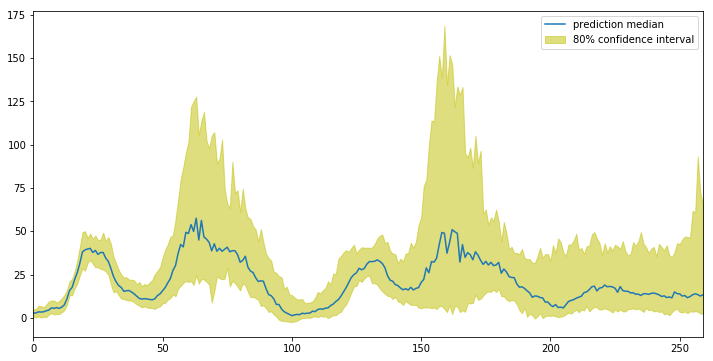

In [50]:
display_quantiles(predictions_sj, None)

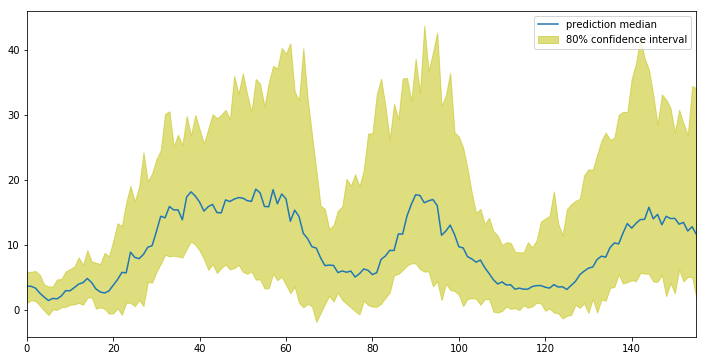

In [51]:
display_quantiles(predictions_iq, None)

## Creating output CSV for submission

In [140]:
def create_submission(predictions_sj, predictions_iq, template_file='./data/submission_format.csv', output_dir='./submissions'):
    submission = pd.read_csv(template_file)
    submission.loc[submission.city=='iq', 'total_cases'] = predictions_iq['0.5'].tolist()
    submission.loc[submission.city=='sj', 'total_cases'] = predictions_sj['0.5'].tolist()
    submission['total_cases'] = submission['total_cases'].round().astype(int)
    submission.to_csv(f'{output_dir}/submission_{str.replace(str(pd.Timestamp.now()), " ", "_")}.csv', index=False)

In [142]:
create_submission(predictions_sj, predictions_iq)